**1. Setup and Dataset Loading**

In [ ]:
# Install required libraries
!pip install -q scikit-learn matplotlib seaborn

# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import re
from google.colab import files

# Load the dataset
print("Please upload your dataset (CSV format).")
uploaded = files.upload()

# Read the uploaded file
for filename in uploaded.keys():
    dataset = pd.read_csv(filename)

print("Dataset loaded successfully.")
print(dataset.head())  # Display the first few rows for verification


Please upload your dataset (CSV format).


Saving labeled_dataset.csv to labeled_dataset.csv
Dataset loaded successfully.
   id                              task              job_role complexity  \
0   1              Write and debug code  Full Stack Developer     Medium   
1   2                       Design APIs  Full Stack Developer     Medium   
2   3  Design wireframes and prototypes        UI/UX Designer        Low   
3   4        Manage database operations  Full Stack Developer        Low   
4   5             Conduct user research        Data Scientist     Medium   

    task_type creativity human_interaction time_taken frequency   skill_level  \
0   Technical   Moderate               Low   Full-day   Monthly  Intermediate   
1   Technical       High               Low   Full-day   Monthly      Beginner   
2    Creative   Moderate               Low   Half-day    Weekly      Beginner   
3   Technical        Low          Moderate   Half-day    Weekly  Intermediate   
4  Analytical   Moderate               Low   Full-day   Mon

**2. Data Preprocessing**

In [ ]:
# Preprocess job descriptions
def preprocess_description(description):
    sentences = re.split(r'[.\n;]', str(description))
    cleaned_sentences = [re.sub(r"[^a-zA-Z\s]", "", sentence).strip().lower() for sentence in sentences if sentence.strip()]
    return cleaned_sentences

# Map tasks to skills using a taxonomy
skill_taxonomy = {
    'problem-solving': ['debug', 'troubleshoot', 'analyze', 'optimize'],
    'teamwork': ['collaborate', 'coordinate', 'work with'],
    'technical skills': ['develop', 'implement', 'design', 'code'],
    'communication': ['present', 'communicate', 'explain']
}

def map_to_skills(tasks):
    task_to_skill = []
    for task in tasks:
        task_skills = [skill for skill, keywords in skill_taxonomy.items() if any(keyword in task for keyword in keywords)]
        task_to_skill.append(", ".join(task_skills) if task_skills else "other")
    return task_to_skill

# Apply preprocessing to dataset
dataset['Tasks'] = dataset['Job_Description'].fillna('').apply(preprocess_description)
dataset['Mapped_Skills'] = dataset['Tasks'].apply(map_to_skills)

# Extract text features using TF-IDF
vectorizer = TfidfVectorizer(max_features=500)
text_features = vectorizer.fit_transform(dataset['Job_Description'].fillna(''))

# Prepare categorical features
categorical_columns = ['complexity', 'task_type', 'creativity', 'human_interaction']
encoder = OneHotEncoder(sparse_output=False)
categorical_encoded = encoder.fit_transform(dataset[categorical_columns].fillna('Unknown'))


**3. Training Section**

In [ ]:
from imblearn.over_sampling import SMOTE
# Combine features
X = np.hstack([categorical_encoded, text_features.toarray()])
y = dataset['Automation_Risk'].map({'Low Risk': 0, 'Medium Risk': 1, 'High Risk': 2})  # Encode target variable

# Split data into training and testing sets
# Step 1: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Apply SMOTE to training data ONLY
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("Applied SMOTE Oversampling to balance class distribution.")

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=10,
    class_weight={0: 1, 1: 1, 2: 4},  # Reduce weight for Class 2
    random_state=42
)

rf_model.fit(X_train, y_train)
print("Random Forest Training Completed with Class Weights.")


Applied SMOTE Oversampling to balance class distribution.
Random Forest Training Completed with Class Weights.


**4. Testing Section**

Accuracy: 93.20%
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.92      0.80       202
           1       0.99      0.93      0.96      1781
           2       0.27      1.00      0.42        17

    accuracy                           0.93      2000
   macro avg       0.66      0.95      0.73      2000
weighted avg       0.96      0.93      0.94      2000



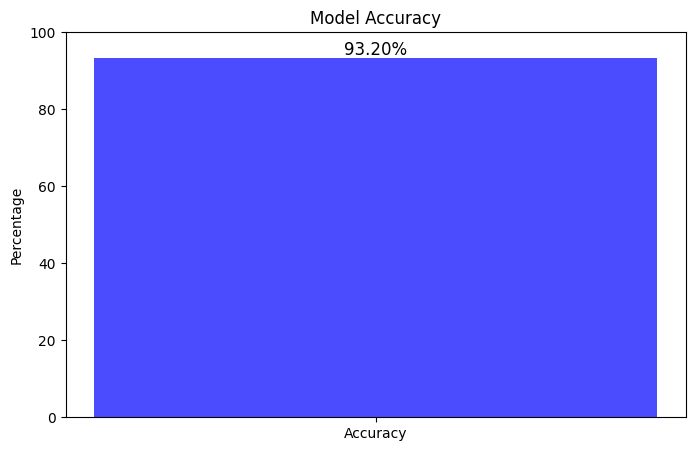

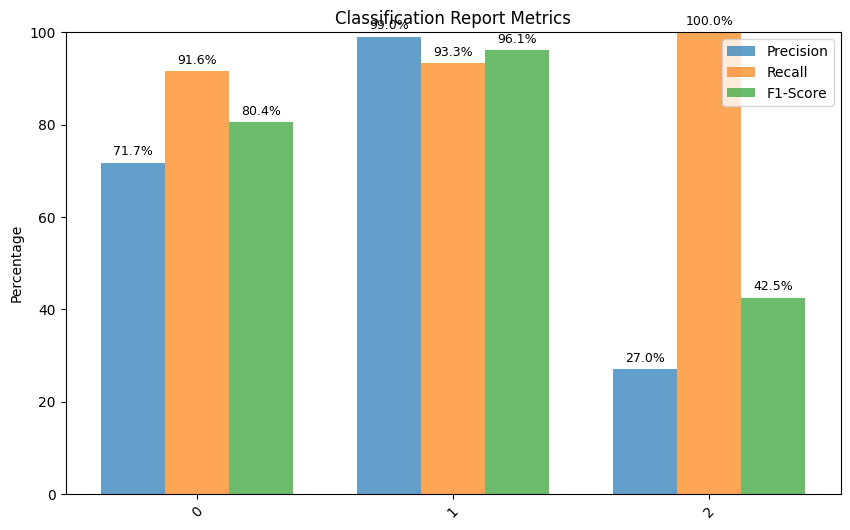

Enter a task or description: execute test cases
Recommendations:
          job_role Automation_Risk Mapped_Skills
5013  QA Engineer     Medium Risk       [other]
5846  QA Engineer     Medium Risk       [other]
9155  QA Engineer     Medium Risk       [other]
9749  QA Engineer     Medium Risk       [other]
7863  QA Engineer     Medium Risk       [other]


In [ ]:
import numpy as np
# Evaluate the model
# Generate predictions
y_probs = rf_model.predict_proba(X_test)
# Increase threshold for Class 2 predictions (0.2 → 0.5)
y_pred = np.where(y_probs[:, 2] > 0.7, 2, rf_model.predict(X_test))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Extract metrics from classification report
classes = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', and 'weighted avg'
precision = [report[cls]['precision'] * 100 for cls in classes]
recall = [report[cls]['recall'] * 100 for cls in classes]
f1_score = [report[cls]['f1-score'] * 100 for cls in classes]

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.bar(["Accuracy"], [accuracy * 100], color='blue', alpha=0.7)
plt.title("Model Accuracy")
plt.ylabel("Percentage")
plt.ylim(0, 100)
plt.text(0, accuracy * 100, f"{accuracy * 100:.2f}%", ha='center', va='bottom', fontsize=12)
plt.show()

# Plot Classification Report Metrics
x = np.arange(len(classes))
width = 0.25  # Width of the bars

plt.figure(figsize=(10, 6))
plt.bar(x - width, precision, width, label='Precision', alpha=0.7)
plt.bar(x, recall, width, label='Recall', alpha=0.7)
plt.bar(x + width, f1_score, width, label='F1-Score', alpha=0.7)

plt.title("Classification Report Metrics")
plt.ylabel("Percentage")
plt.xticks(x, classes, rotation=45)
plt.ylim(0, 100)
plt.legend()

# Add percentages on bars
for i, (p, r, f1) in enumerate(zip(precision, recall, f1_score)):
    plt.text(i - width, p + 1, f"{p:.1f}%", ha='center', va='bottom', fontsize=9)
    plt.text(i, r + 1, f"{r:.1f}%", ha='center', va='bottom', fontsize=9)
    plt.text(i + width, f1 + 1, f"{f1:.1f}%", ha='center', va='bottom', fontsize=9)

plt.show()

# Recommendation System
def get_recommendations_from_input(job_description, top_n=5):
    processed_input = preprocess_description(job_description)
    input_text_vectorized = vectorizer.transform([" ".join(processed_input)]).toarray()
    input_features = np.hstack([np.zeros((1, categorical_encoded.shape[1])), input_text_vectorized])

    # Compute similarity
    similarity_scores = cosine_similarity(input_features, X)
    similar_indices = similarity_scores.argsort()[0, -top_n:][::-1]
    recommendations = dataset.iloc[similar_indices]
    return recommendations[['job_role', 'Automation_Risk', 'Mapped_Skills']]

# Example usage
job_description = input("Enter a task or description: ")
recommendations = get_recommendations_from_input(job_description)
print("Recommendations:\n", recommendations)
